# MAME 3D LUT generator

The MAME emulator supports colour correction via a 3D LUT.

The LUT is a 64x64x64 lookup (6-bit per channel, or 18-bit total) stored as a 4096x64 pixel PNG file. 

The unchanged "identity" LUT looks like the following:

The top most layer's four corner RGB triplets are:
* Top-left = 0,0,0 (black)
* Top-right = 255,0,0 (red)
* Bottom-left = 0,255,0 (green)
* Bottom-rght = 255,255,0 (yellow)

The bottom most layer's four corner RGB triplets are:
* Top-left = 0,0,255 (blue)
* Top-right = 255,0,255 (magenta)
* Bottom-left = 0,255,255 (cyan)
* Bottom-rght = 255,255,255 (white)

This notebook applies all of the adaptation matrices in this repo to generate new LUTs that can be applied to simulate the various colourspaces on offer. 

In [1]:
from PIL import Image
import numpy as np
import csv
import inspect

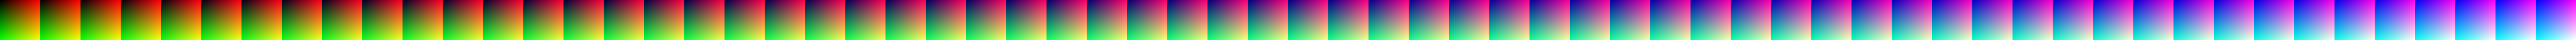

In [2]:
# Create empty arrays for the LUTs
# Must be dtype=uint8 for an 8bit RGB PNG file

lut = np.zeros((64,4096,3), dtype=np.uint8)

# Calculate our RGB pixel values based on their co-ordinates in the array
# These are normalised RGB ranges 0.0 - 1.0
for lut_row in range(lut.shape[0]):
    for lut_col in range(lut.shape[1]):
        r = (lut_col % 64) / 63
        g = (lut_row) / 63
        b = np.trunc(lut_col/64) / 63
        # pixel array will be float, which we want for matrix calculations
        # but will be rounded to uint8 when inserted into lut arrays
        pixel = np.array([r, g, b])
        # change from normalised to 8bit
        pixel_8bit = np.rint(pixel*255)
        # insert pixel into lut array
        lut[[lut_row],[lut_col]] = pixel_8bit
        
# create a Pillow Image
lut_image = Image.fromarray(lut, mode="RGB")
# Write image to a file
lut_image.save("../mame/artwork/lut_mame_default.png")
# display image to screen
display(lut_image)


In [3]:
## Read in matrices
with open('../csv/matrix_XYZ.csv') as f:
    matrix_dict = csv.DictReader(f)
    for cspace in matrix_dict:
        # Our destination matrix for computers will be sRGB
        if cspace['col_id'] == 'sRGB':
            XYZ_to_sRGB = np.array([float(cspace['Mdst0']), float(cspace['Mdst1']), float(cspace['Mdst2']),
                                    float(cspace['Mdst3']), float(cspace['Mdst4']), float(cspace['Mdst5']),
                                    float(cspace['Mdst6']), float(cspace['Mdst7']), float(cspace['Mdst8'])])
            XYZ_to_sRGB = np.reshape(XYZ_to_sRGB, (3,3))
        # Source matrices only from here
        elif cspace['col_id'] == 'ARIBTRB9v1':
            ARIBTRB9v1_to_XYZ = np.array([float(cspace['Msrc0']), float(cspace['Msrc1']), float(cspace['Msrc2']),
                                          float(cspace['Msrc3']), float(cspace['Msrc4']), float(cspace['Msrc5']),
                                          float(cspace['Msrc6']), float(cspace['Msrc7']), float(cspace['Msrc8'])])
            ARIBTRB9v1_to_XYZ = np.reshape(ARIBTRB9v1_to_XYZ, (3,3))
        elif cspace['col_id'] == 'sRGB_D93':
            sRGB_D93_to_XYZ = np.array([float(cspace['Msrc0']), float(cspace['Msrc1']), float(cspace['Msrc2']),
                                        float(cspace['Msrc3']), float(cspace['Msrc4']), float(cspace['Msrc5']),
                                        float(cspace['Msrc6']), float(cspace['Msrc7']), float(cspace['Msrc8'])])
            sRGB_D93_to_XYZ = np.reshape(sRGB_D93_to_XYZ, (3,3))
        elif cspace['col_id'] == 'Raney_PVM_20M2U':
            Raney_PVM_20M2U_to_XYZ = np.array([float(cspace['Msrc0']), float(cspace['Msrc1']), float(cspace['Msrc2']),
                                               float(cspace['Msrc3']), float(cspace['Msrc4']), float(cspace['Msrc5']),
                                               float(cspace['Msrc6']), float(cspace['Msrc7']), float(cspace['Msrc8'])])
            Raney_PVM_20M2U_to_XYZ = np.reshape(Raney_PVM_20M2U_to_XYZ, (3,3))
        elif cspace['col_id'] == 'Raney_PVM_20L2MDU':
            Raney_PVM_20L2MDU_to_XYZ = np.array([float(cspace['Msrc0']), float(cspace['Msrc1']), float(cspace['Msrc2']),
                                              float(cspace['Msrc3']), float(cspace['Msrc4']), float(cspace['Msrc5']),
                                              float(cspace['Msrc6']), float(cspace['Msrc7']), float(cspace['Msrc8'])])
            Raney_PVM_20L2MDU_to_XYZ = np.reshape(Raney_PVM_20L2MDU_to_XYZ, (3,3))


In [4]:
## Use our matrices above to create all of our LUTs
## MAME has internal gamma correction via the `-gamma` flag, so we don't need to bake gamma correction in
## But due to SDR clipping, we'll offer 75%-100% scaled versions

matrices = []
matrices.append(["lut_ARIBTRB9v1_",ARIBTRB9v1_to_XYZ])
matrices.append(["lut_sRGB_D93_",sRGB_D93_to_XYZ])
matrices.append(["lut_Raney_PVM_20M2U_",Raney_PVM_20M2U_to_XYZ])
matrices.append(["lut_Raney_PVM_20L2MDU_",Raney_PVM_20L2MDU_to_XYZ])

lut = np.zeros((64,4096,3), dtype=np.uint8)

for name, src_matrix in matrices:
    for scale in range(75, 101, 5):
        for lut_row in range(lut.shape[0]):
            for lut_col in range(lut.shape[1]):
                r = (lut_col % 64) / 63
                g = (lut_row) / 63
                b = np.trunc(lut_col/64) / 63
                pixel_in = np.array([r, g, b])
                pixel_in = pixel_in ** 2.2
                pixel_src = np.matmul(src_matrix, pixel_in)
                pixel_src = pixel_src*(scale/100)
                pixel_dst = np.clip(np.matmul(XYZ_to_sRGB, pixel_src), 0, 1)
                pixel_dst = pixel_dst ** (1/2.2)
                pixel_8bit = np.rint(pixel_dst*255)
                lut[lut_row][lut_col] = pixel_8bit
        filename = "../mame/artwork/"+name+str(scale).zfill(3)+"_percent.png"
        im = Image.fromarray(lut, mode="RGB")
        im.save(filename)
        print("Saved file: "+str(filename))

Saved file: ../mame/artwork/lut_ARIBTRB9v1_075_percent.png
Saved file: ../mame/artwork/lut_ARIBTRB9v1_080_percent.png
Saved file: ../mame/artwork/lut_ARIBTRB9v1_085_percent.png
Saved file: ../mame/artwork/lut_ARIBTRB9v1_090_percent.png
Saved file: ../mame/artwork/lut_ARIBTRB9v1_095_percent.png
Saved file: ../mame/artwork/lut_ARIBTRB9v1_100_percent.png
Saved file: ../mame/artwork/lut_sRGB_D93_075_percent.png
Saved file: ../mame/artwork/lut_sRGB_D93_080_percent.png
Saved file: ../mame/artwork/lut_sRGB_D93_085_percent.png
Saved file: ../mame/artwork/lut_sRGB_D93_090_percent.png
Saved file: ../mame/artwork/lut_sRGB_D93_095_percent.png
Saved file: ../mame/artwork/lut_sRGB_D93_100_percent.png
Saved file: ../mame/artwork/lut_Raney_PVM_20M2U_075_percent.png
Saved file: ../mame/artwork/lut_Raney_PVM_20M2U_080_percent.png
Saved file: ../mame/artwork/lut_Raney_PVM_20M2U_085_percent.png
Saved file: ../mame/artwork/lut_Raney_PVM_20M2U_090_percent.png
Saved file: ../mame/artwork/lut_Raney_PVM_20M2U_